In [1]:
#setup
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr

In [2]:
#read data
data = pd.read_csv("obt_slim.csv")

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


/var/folders/f4/gmbjrwrj2llb8qgk7x9xssxr0000gp/T/ipykernel_18759/3860814092.py:2: DtypeWarning: Columns (6,10,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("obt_slim.csv")


# SDOH Explore
We are interested in these sdoh variables: 

summary scores = [`series_themes_sum`,`socioeconomic_status_sum`,`hh_characteristics_sum`,`minority_status_sum`,`housing_status_sum`]

percentiles = [`overall_percentile_ranking`,`socioeconomic_status_percentile_rank`,`hh_characteristics_percentile_rank`,`minority_status_percentile_rank`,`housing_status_percentile_rank`]

`series_themes_sum` and `overall_percentile_ranking` are aggregate social vulnerability index (SVI) measures across the four specific categories: socioeconomic status, household characteristics (`hh_characteristics`), minority status, and housing status)

In [3]:
sdoh_summary_scores = ['series_themes_sum',"socioeconomic_status_sum","hh_characteristics_sum","minority_status_sum","housing_status_sum"]
sdoh_percentiles = ["overall_percentile_ranking","socioeconomic_status_percentile_rank","hh_characteristics_percentile_rank","minority_status_percentile_rank","housing_status_percentile_rank"]

In [8]:
#subsetting data for sdoh measures only
sdoh = data[sdoh_summary_scores+sdoh_percentiles]
sdoh = sdoh[sdoh['series_themes_sum'] > 0]
#descriptive stats of each sdoh measure
sdoh.describe()

,series_themes_sum,socioeconomic_status_sum,hh_characteristics_sum,minority_status_sum,housing_status_sum,overall_percentile_ranking,socioeconomic_status_percentile_rank,hh_characteristics_percentile_rank,minority_status_percentile_rank,housing_status_percentile_rank
count,12358.000000,12358.000000,12358.000000,12358.000000,12358.000000,12358.000000,12358.000000,12358.000000,12358.000000,12358.000000
mean,8.475289,2.660483,2.574393,0.465961,2.774452,0.605413,0.547576,0.556711,0.465961,0.689290
std,1.955238,0.956925,0.649698,0.266333,0.746724,0.251750,0.259815,0.286903,0.266333,0.251044
min,2.356900,0.125500,0.015700,0.000000,0.000000,0.002600,0.000900,0.000500,0.000000,0.000000
25%,7.135400,1.953000,2.186500,0.236900,2.347825,0.421600,0.341300,0.320900,0.236900,0.534250
50%,8.516600,2.705300,2.631100,0.458900,2.868400,0.635400,0.569300,0.595600,0.458900,0.755000
75%,9.888300,3.397400,3.014600,0.687500,3.312400,0.812000,0.763900,0.803600,0.687500,0.894100
max,13.323900,4.871300,4.318600,0.995900,4.578800,0.999500,0.999800,0.999600,0.995900,1.000000


<AxesSubplot:xlabel='series_themes_sum', ylabel='Count'>

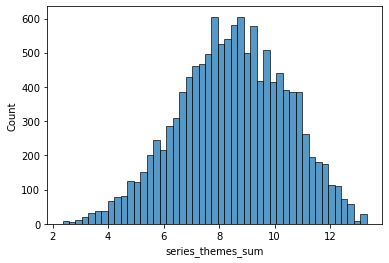

In [9]:
#histogram of overall sdoh summary score
sns.histplot(data = sdoh, x = "series_themes_sum")

Overall SDOH summary score (`series_themes_sum`) is roughly normally distributed, percentile scores will not be. Going to focus on only summary scores for simplicity.

In [10]:
#mean centering summary variables
#create function to center data
center_function = lambda x: x - x.mean()

#apply function to original NumPy array
sdoh_summary_centered = center_function(sdoh[sdoh_summary_scores])

#view mean centered data
sdoh_summary_centered.head()

,series_themes_sum,socioeconomic_status_sum,hh_characteristics_sum,minority_status_sum,housing_status_sum
0,2.622111,1.501417,0.709507,0.339739,0.071448
1,2.622111,1.501417,0.709507,0.339739,0.071448
2,2.622111,1.501417,0.709507,0.339739,0.071448
3,0.593511,0.288017,0.596607,-0.232661,-0.058452
4,0.593511,0.288017,0.596607,-0.232661,-0.058452


<AxesSubplot:>

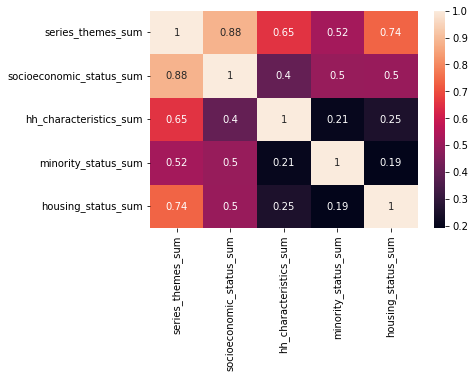

In [11]:
#relationship between sdoh measures
sns.heatmap(sdoh_summary_centered.corr(),annot=True)

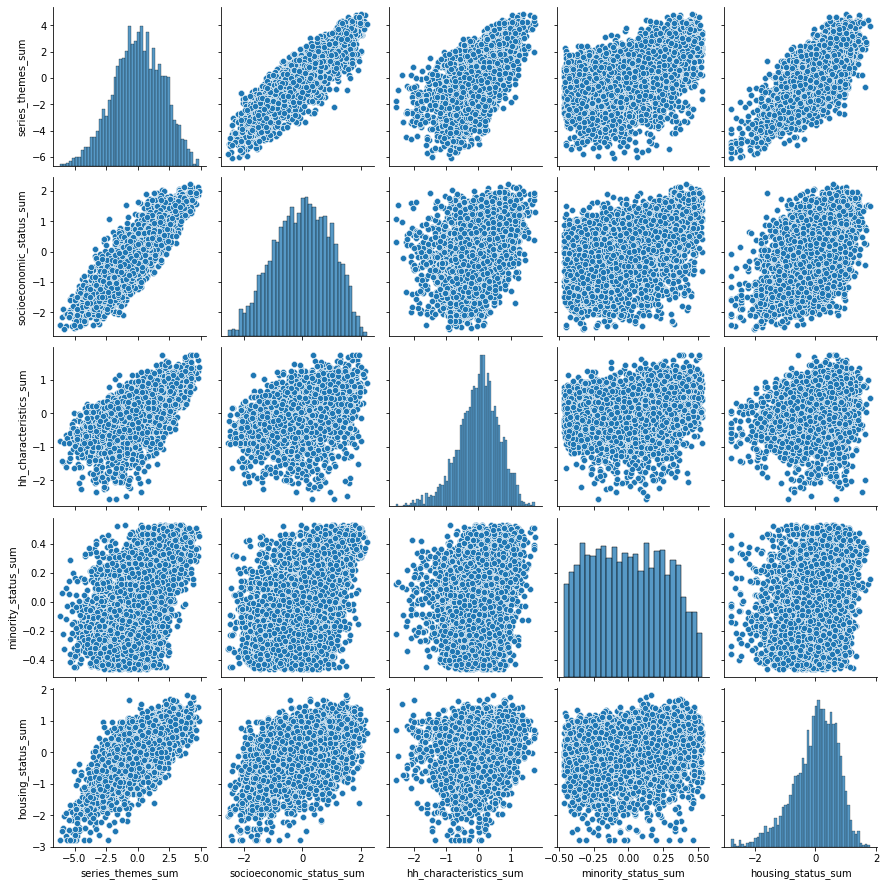

In [12]:
sns.pairplot(data = sdoh_summary_centered)

Overall sdoh summary score is most strongly correlated with socioeconomic status, then housing status, then household characteristics, and lastly minority status.

Minority status and housing status summary scores are not normally distributed.

# Census-Level Relating SDOH and Readmission Rates

In [16]:
#group by county and condition (we only have county level sdoh)
#aggregating sums of number_of_discharges and number_of_readmissions, but mean for overall sdoh sum measure
#predicted/expected readmission ratios are probably not helpful here we shouldn't aggregate over ratios

#filter out -999
data = data[data['series_themes_sum'] > 0]
data_census = (data.groupby(['fips','condition_name'], as_index=False)
       .agg({'number_of_discharges':'sum', 'number_of_readmissions':'sum','series_themes_sum':'mean'})
       .rename(columns={'Missed':'Sum1', 'Credit':'Sum2','Grade':'Average'}))
data_census.head()

,fips,condition_name,number_of_discharges,number_of_readmissions,series_themes_sum
0,1001020300,Chronic Obstructive Pulmonary Disease,127.0,17.0,7.6503
1,1001020300,Heart Failure,134.0,26.0,7.6503
2,1001020300,Pneumonia,151.0,24.0,7.6503
3,1003010500,Chronic Obstructive Pulmonary Disease,0.0,0.0,7.2909
4,1003010500,Heart Failure,0.0,0.0,7.2909


In [17]:
#add calculated raw_readmission_rate
data_census["raw_readmission_rate"] = data_census.number_of_readmissions / data_census.number_of_discharges * 100
data_census.head()

,fips,condition_name,number_of_discharges,number_of_readmissions,series_themes_sum,raw_readmission_rate
0,1001020300,Chronic Obstructive Pulmonary Disease,127.0,17.0,7.6503,13.385827
1,1001020300,Heart Failure,134.0,26.0,7.6503,19.402985
2,1001020300,Pneumonia,151.0,24.0,7.6503,15.894040
3,1003010500,Chronic Obstructive Pulmonary Disease,0.0,0.0,7.2909,NaN
4,1003010500,Heart Failure,0.0,0.0,7.2909,NaN


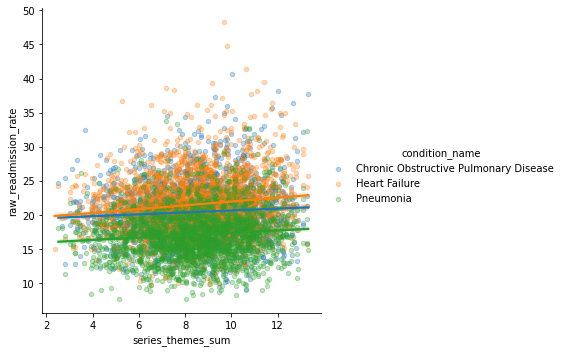

In [23]:
#plotting relationship between raw_readmission_rate, series_themes_sum, and condition_name
sns.lmplot(data = data_census, x = "series_themes_sum", y = "raw_readmission_rate",hue = "condition_name",scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'alpha': 1})

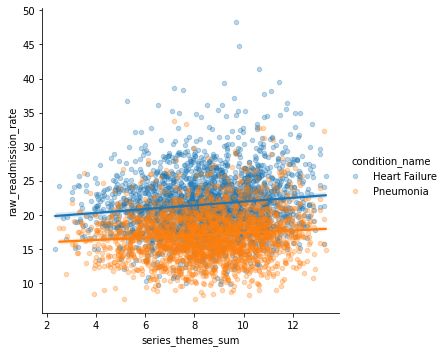

In [25]:
#only HF and pneumonia
data_census_HF_PN = data_census[data_census['condition_name'] != 'Chronic Obstructive Pulmonary Disease']
sns.lmplot(data = data_census_HF_PN, x = "series_themes_sum", y = "raw_readmission_rate",hue = "condition_name",scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'alpha': 1})

In [12]:
#TODO: calculate Rs and significance

#subset dataframe by condition
heart_failure = data_county.loc[data_county['condition_name'] == "Heart Failure"]
pneumonia = data_county.loc[data_county['condition_name'] == "Pneumonia"]
COPD = data_county.loc[data_county['condition_name'] == "Chronic Obstructive Pulmonary Disease"]

#calculate condition specific correlations
#pearsonr(heart_failure['series_themes_sum'],heart_failure['raw_readmission_rate'])

# Hospital-Level: Hospital Ownership & Readmission Rates

In [61]:
#filter out copd
data_filt = data[data['condition_name'] != 'Chronic Obstructive Pulmonary Disease']

#subsetting relevant data
measures_of_interest = [
    "hospital_ownership",
    "patient_safety_score",
    "readmission_rate"]

hospital_quality = data_filt[measures_of_interest]

#descriptive stats
hospital_quality.describe()

,patient_safety_score,readmission_rate
count,5824.000000,4779.000000
mean,0.975893,18.834903
std,0.162386,4.560939
min,0.500000,7.000000
25%,0.890000,16.000000
50%,0.960000,18.000000
75%,1.040000,22.000000
max,2.700000,48.000000


hospital_ownership
Tribal                                            1
Government - Federal                             15
Physician                                        23
Government - State                               57
Government - Local                              220
Government - Hospital District or Authority     320
Voluntary non-profit - Church                   411
Voluntary non-profit - Other                    437
Proprietary                                     906
Voluntary non-profit - Private                 2383
Name: readmission_rate, dtype: int64


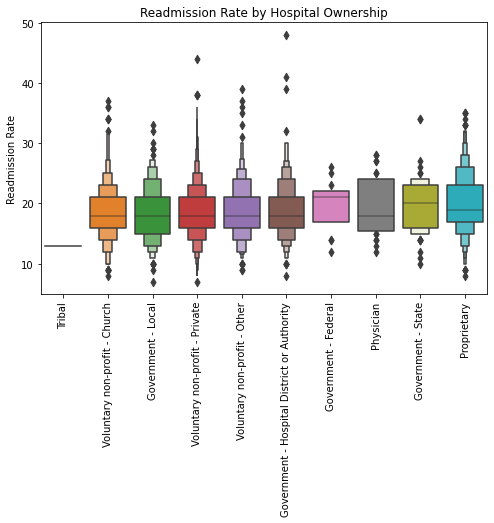

In [62]:
#calculate metric for order box plots (by median readmission rates)
group_counts=hospital_quality.groupby(['hospital_ownership'])['readmission_rate'].count().sort_values(ascending=True)
print(group_counts)
group_means = hospital_quality.groupby(['hospital_ownership'])['readmission_rate'].mean().sort_values(ascending=True)

fig,ax = plt.subplots(figsize=(8,5))
sns.boxenplot(data=hospital_quality, x="hospital_ownership", y="readmission_rate",order=group_means.index)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
_ = ax.set(ylabel="Readmission Rate", xlabel="", title="Readmission Rate by Hospital Ownership")
 
# Add counts to the plot (only works if order by count)
# pos = range(len(nobs))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick],
#             18,
#             group_counts[tick],
#             horizontalalignment='center',
#             size='x-small',
#             color='w',
#             weight='semibold')
 
# plt.show()

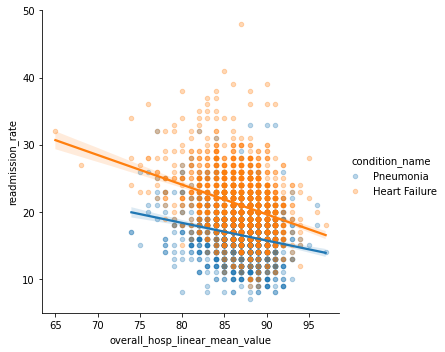

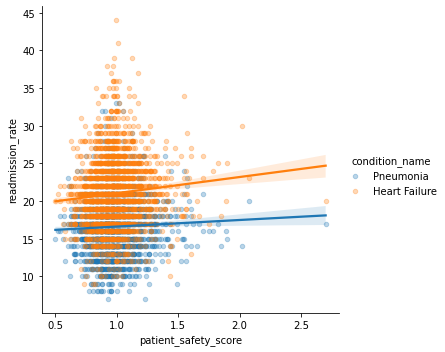

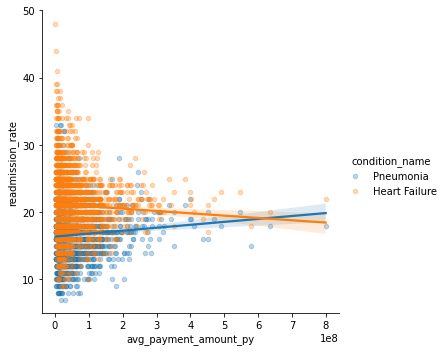

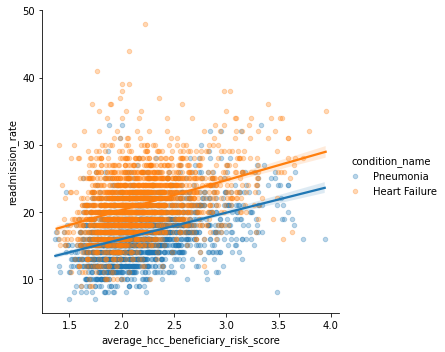

In [65]:
for col in ['overall_hosp_linear_mean_value', 'patient_safety_score','avg_payment_amount_py','average_hcc_beneficiary_risk_score']:
    sns.lmplot(x=col, y='readmission_rate', data=data_filt,hue = "condition_name",scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'alpha': 1})
    plt.show()